In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
cudnn.benchmark = True
plt.ion()  

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '//kaggle/input/hymenoptera/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

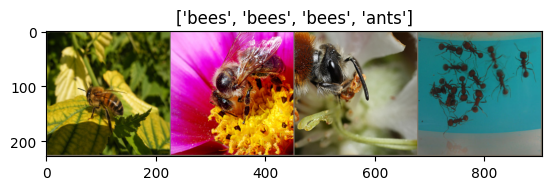

In [5]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 141MB/s] 


In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5585 Acc: 0.7254
val Loss: 0.1705 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4177 Acc: 0.8197
val Loss: 0.4851 Acc: 0.8170

Epoch 2/24
----------
train Loss: 0.4151 Acc: 0.8238
val Loss: 0.1884 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4336 Acc: 0.8115
val Loss: 0.2472 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.4381 Acc: 0.8074
val Loss: 0.3317 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.5516 Acc: 0.8074
val Loss: 0.3179 Acc: 0.8497

Epoch 6/24
----------
train Loss: 0.3794 Acc: 0.8484
val Loss: 0.3282 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3343 Acc: 0.8648
val Loss: 0.2786 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.2573 Acc: 0.8893
val Loss: 0.2597 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3191 Acc: 0.8648
val Loss: 0.2385 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2217 Acc: 0.9057
val Loss: 0.2455 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2804 Acc: 0.8893
val Loss: 0.2205 Acc: 0.9346

Ep

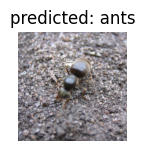

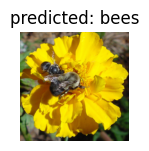

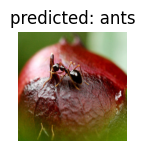

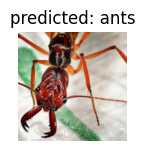

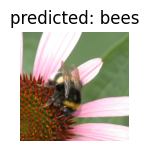

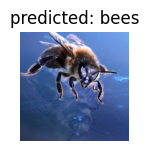

In [10]:
visualize_model(model_ft)

In [11]:
model_conv = torchvision.models.resnet50(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5880 Acc: 0.6885
val Loss: 0.2289 Acc: 0.9216

Epoch 1/9
----------
train Loss: 0.3938 Acc: 0.8361
val Loss: 0.1895 Acc: 0.9346

Epoch 2/9
----------
train Loss: 0.3606 Acc: 0.8443
val Loss: 0.1534 Acc: 0.9346

Epoch 3/9
----------
train Loss: 0.4459 Acc: 0.7910
val Loss: 0.1438 Acc: 0.9412

Epoch 4/9
----------
train Loss: 0.4652 Acc: 0.8115
val Loss: 0.1248 Acc: 0.9608

Epoch 5/9
----------
train Loss: 0.4773 Acc: 0.8033
val Loss: 0.1716 Acc: 0.9085

Epoch 6/9
----------
train Loss: 0.6520 Acc: 0.7869
val Loss: 0.2757 Acc: 0.8693

Epoch 7/9
----------
train Loss: 0.3083 Acc: 0.8648
val Loss: 0.1446 Acc: 0.9412

Epoch 8/9
----------
train Loss: 0.2741 Acc: 0.8730
val Loss: 0.1194 Acc: 0.9673

Epoch 9/9
----------
train Loss: 0.3085 Acc: 0.8607
val Loss: 0.1378 Acc: 0.9542

Training complete in 0m 22s
Best val Acc: 0.967320


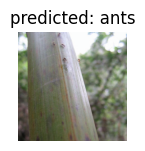

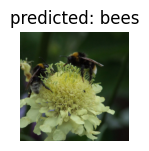

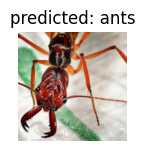

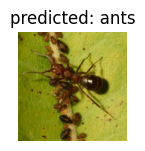

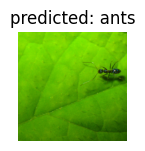

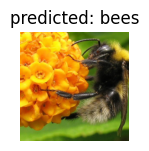

In [13]:
visualize_model(model_conv)
plt.ioff()
plt.show()

In [19]:
# Import the VGG16 model
model_vgg16 = models.vgg16(pretrained=True)
for param in model_vgg16.parameters():
    param.requires_grad = False
num_features = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_features, len(class_names))
model_vgg16 = model_vgg16.to(device)
criterion_vgg16 = nn.CrossEntropyLoss()
optimizer_vgg16 = optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler_vgg16 = lr_scheduler.StepLR(optimizer_vgg16, step_size=7, gamma=0.1)
model_vgg16 = train_model(model_vgg16, criterion_vgg16, optimizer_vgg16, exp_lr_scheduler_vgg16, num_epochs=10)


Epoch 0/9
----------
train Loss: 0.4016 Acc: 0.8484
val Loss: 0.0627 Acc: 0.9869

Epoch 1/9
----------
train Loss: 0.2851 Acc: 0.9057
val Loss: 0.1204 Acc: 0.9477

Epoch 2/9
----------
train Loss: 0.1626 Acc: 0.9180
val Loss: 0.0785 Acc: 0.9804

Epoch 3/9
----------
train Loss: 0.1869 Acc: 0.9344
val Loss: 0.1084 Acc: 0.9542

Epoch 4/9
----------
train Loss: 0.1273 Acc: 0.9549
val Loss: 0.0875 Acc: 0.9673

Epoch 5/9
----------
train Loss: 0.2466 Acc: 0.9221
val Loss: 0.1271 Acc: 0.9542

Epoch 6/9
----------
train Loss: 0.1636 Acc: 0.9590
val Loss: 0.1831 Acc: 0.9477

Epoch 7/9
----------
train Loss: 0.1480 Acc: 0.9467
val Loss: 0.1530 Acc: 0.9542

Epoch 8/9
----------
train Loss: 0.1497 Acc: 0.9344
val Loss: 0.1480 Acc: 0.9542

Epoch 9/9
----------
train Loss: 0.2020 Acc: 0.9426
val Loss: 0.1383 Acc: 0.9542

Training complete in 0m 24s
Best val Acc: 0.986928


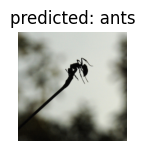

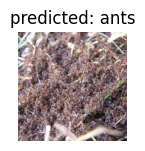

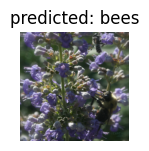

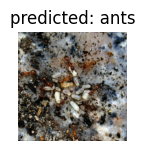

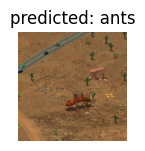

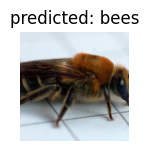

In [15]:
visualize_model(model_vgg16)



In [17]:
model_resnet152 = models.resnet152(pretrained=True)
for param in model_resnet152.parameters():
    param.requires_grad = False
num_features = model_resnet152.fc.in_features
model_resnet152.fc = nn.Linear(num_features, len(class_names))
model_resnet152 = model_resnet152.to(device)
criterion_resnet152 = nn.CrossEntropyLoss()
optimizer_resnet152 = optim.SGD(model_resnet152.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler_resnet152 = lr_scheduler.StepLR(optimizer_resnet152, step_size=7, gamma=0.1)
model_resnet152 = train_model(model_resnet152, criterion_resnet152, optimizer_resnet152, exp_lr_scheduler_resnet152, num_epochs=10)


Epoch 0/9
----------
train Loss: 0.5960 Acc: 0.6475
val Loss: 0.1529 Acc: 0.9412

Epoch 1/9
----------
train Loss: 0.3851 Acc: 0.8402
val Loss: 0.1517 Acc: 0.9477

Epoch 2/9
----------
train Loss: 0.3578 Acc: 0.8402
val Loss: 0.1382 Acc: 0.9542

Epoch 3/9
----------
train Loss: 0.7192 Acc: 0.6926
val Loss: 0.1944 Acc: 0.9216

Epoch 4/9
----------
train Loss: 0.4584 Acc: 0.7951
val Loss: 0.1455 Acc: 0.9281

Epoch 5/9
----------
train Loss: 0.4803 Acc: 0.7910
val Loss: 0.0841 Acc: 0.9608

Epoch 6/9
----------
train Loss: 0.4774 Acc: 0.8115
val Loss: 0.1089 Acc: 0.9608

Epoch 7/9
----------
train Loss: 0.2855 Acc: 0.8770
val Loss: 0.1049 Acc: 0.9608

Epoch 8/9
----------
train Loss: 0.2262 Acc: 0.9180
val Loss: 0.0997 Acc: 0.9673

Epoch 9/9
----------
train Loss: 0.3511 Acc: 0.8402
val Loss: 0.1057 Acc: 0.9608

Training complete in 0m 39s
Best val Acc: 0.967320


<Figure size 640x480 with 0 Axes>

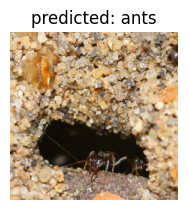

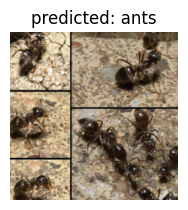

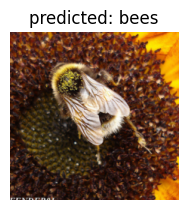

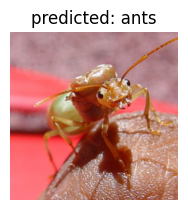

In [21]:
visualize_model(model_resnet152,num_images=4)